In [1]:
!git clone https://github.com/chuanenlin/lane-detector.git
%cd lane-detector
%ls

Cloning into 'lane-detector'...
remote: Enumerating objects: 17, done.
remote: Total 17 (delta 0), reused 0 (delta 0), pack-reused 17 (from 1)
Receiving objects: 100% (17/17), 6.31 MiB | 16.23 MiB/s, done.
Resolving deltas: 100% (6/6), done.
/content/lane-detector
checkpoint1.py  checkpoint3.py  checkpoint5.py  input.mp4  solution.py
checkpoint2.py  checkpoint4.py  detector.py     README.md


In [2]:
import cv2 as cv
from google.colab.patches import cv2_imshow
import numpy as np

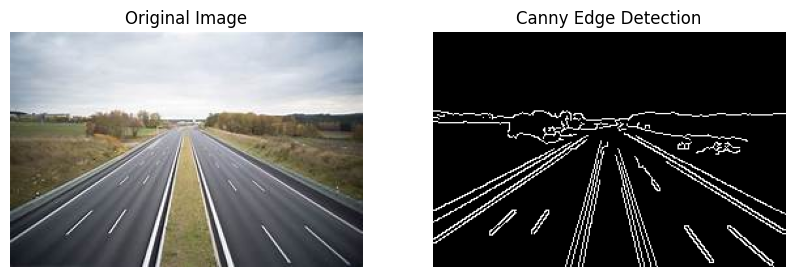

In [9]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def do_canny(frame):
    # Converts frame to grayscale because we only need the luminance channel for detecting edges - less computationally expensive
    gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
    # Applies a 5x5 gaussian blur with deviation of 0 to frame - not mandatory since Canny will do this for us
    blur = cv2.GaussianBlur(gray, (5, 5), 0)
    # Applies Canny edge detector with minVal of 50 and maxVal of 150
    canny = cv2.Canny(blur, 50, 150)
    return canny
frame = cv2.imread('/content/lane.jpg')  # Update with your image path

# Check if the image was loaded properly
if frame is None:
    print("Error: Image not found or could not be loaded.")
else:
    # Proceed with your processing
    canny_edges = do_canny(frame)

    # Display images
    plt.figure(figsize=(10, 5))

    # Original image
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    plt.title('Original Image')
    plt.axis('off')

    # Canny edge detected image
    plt.subplot(1, 2, 2)
    plt.imshow(canny_edges, cmap='gray')
    plt.title('Canny Edge Detection')
    plt.axis('off')

    plt.show()

In [10]:
import cv2 as cv
from google.colab.patches import cv2_imshow
import numpy as np
def do_segment(frame):
    # Since an image is a multi-directional array containing the relative intensities of each pixel in the image, we can use frame.shape to return a tuple: [number of rows, number of columns, number of channels] of the dimensions of the frame
    # frame.shape[0] give us the number of rows of pixels the frame has. Since height begins from 0 at the top, the y-coordinate of the bottom of the frame is its height
    height = frame.shape[0]
    # Creates a triangular polygon for the mask defined by three (x, y) coordinates
    polygons = np.array([
                            [(0, height), (800, height), (380, 290)]
                        ])
    # Creates an image filled with zero intensities with the same dimensions as the frame
    mask = np.zeros_like(frame)
    # Allows the mask to be filled with values of 1 and the other areas to be filled with values of 0
    cv.fillPoly(mask, polygons, 255)
    # A bitwise and operation between the mask and frame keeps only the triangular area of the frame
    segment = cv.bitwise_and(frame, mask)
    return segment

In [11]:
def calculate_lines(frame, lines):
    # Empty arrays to store the coordinates of the left and right lines
    left = []
    right = []
    # Loops through every detected line
    for line in lines:
        # Reshapes line from 2D array to 1D array
        x1, y1, x2, y2 = line.reshape(4)
        # Fits a linear polynomial to the x and y coordinates and returns a vector of coefficients which describe the slope and y-intercept
        parameters = np.polyfit((x1, x2), (y1, y2), 1)
        slope = parameters[0]
        y_intercept = parameters[1]
        # If slope is negative, the line is to the left of the lane, and otherwise, the line is to the right of the lane
        if slope < 0:
            left.append((slope, y_intercept))
        else:
            right.append((slope, y_intercept))
    # Averages out all the values for left and right into a single slope and y-intercept value for each line
    left_avg = np.average(left, axis = 0)
    right_avg = np.average(right, axis = 0)
    # Calculates the x1, y1, x2, y2 coordinates for the left and right lines
    left_line = calculate_coordinates(frame, left_avg)
    right_line = calculate_coordinates(frame, right_avg)
    return np.array([left_line, right_line])

def calculate_coordinates(frame, parameters):
    slope, intercept = parameters
    # Sets initial y-coordinate as height from top down (bottom of the frame)
    y1 = frame.shape[0]
    # Sets final y-coordinate as 150 above the bottom of the frame
    y2 = int(y1 - 150)
    # Sets initial x-coordinate as (y1 - b) / m since y1 = mx1 + b
    x1 = int((y1 - intercept) / slope)
    # Sets final x-coordinate as (y2 - b) / m since y2 = mx2 + b
    x2 = int((y2 - intercept) / slope)
    return np.array([x1, y1, x2, y2])

In [12]:
def visualize_lines(frame, lines):
    # Creates an image filled with zero intensities with the same dimensions as the frame
    lines_visualize = np.zeros_like(frame)
    # Checks if any lines are detected
    if lines is not None:
        for x1, y1, x2, y2 in lines:
            # Draws lines between two coordinates with green color and 5 thickness
            cv.line(lines_visualize, (x1, y1), (x2, y2), (0, 255, 0), 5)
    return lines_visualize

In [7]:
def lane_detector (frame):
    canny = do_canny(frame)
    segment = do_segment(canny)
    hough = cv.HoughLinesP(segment, 2, np.pi / 180, 100, np.array([]), minLineLength = 100, maxLineGap = 50)
    # Averages multiple detected lines from hough into one line for left border of lane and one line for right border of lane
    lines = calculate_lines(frame, hough)
    # Visualizes the lines
    lines_visualize = visualize_lines(frame, lines)
    # Overlays lines on frame by taking their weighted sums and adding an arbitrary scalar value of 1 as the gamma argument
    output = cv.addWeighted(frame, 0.9, lines_visualize, 1, 1)
    return output

Processing Video...
Done processing video


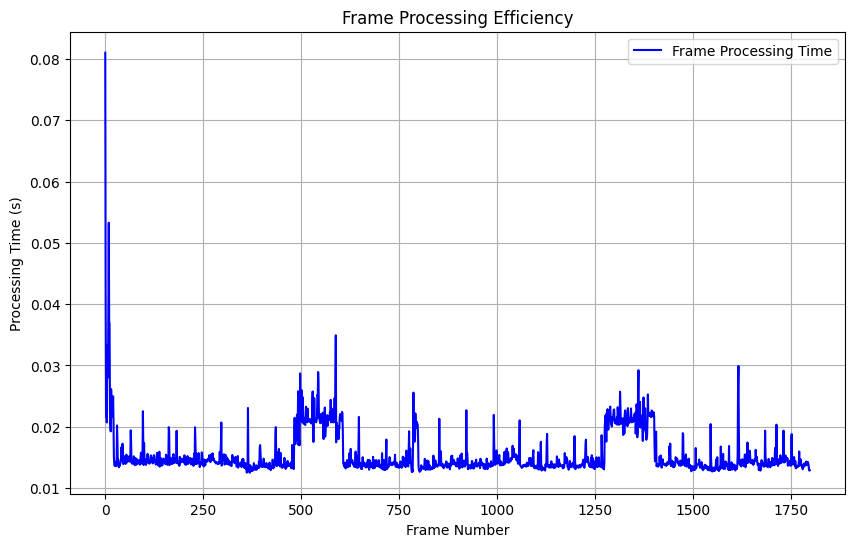

In [8]:
import cv2
import numpy as np
import time
import matplotlib.pyplot as plt

# Initialize metrics
frame_times = []
frame_count = 0

cap = cv2.VideoCapture('input.mp4')
ret, frame = cap.read()
frame_height, frame_width, _ = frame.shape
out = cv2.VideoWriter('output.avi', cv2.VideoWriter_fourcc('M', 'J', 'P', 'G'), 10, (frame_width, frame_height))

print("Processing Video...")
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        out.release()
        break

    # Start timer
    start_time = time.time()

    # Process frame
    output = lane_detector(frame)
    out.write(output)

    # Stop timer and log time
    end_time = time.time()
    frame_time = end_time - start_time
    frame_times.append(frame_time)
    frame_count += 1

out.release()
print("Done processing video")

# Plot efficiency graph
plt.figure(figsize=(10, 6))
plt.plot(range(frame_count), frame_times, label='Frame Processing Time', color='blue')
plt.xlabel('Frame Number')
plt.ylabel('Processing Time (s)')
plt.title('Frame Processing Efficiency')
plt.legend()
plt.grid(True)
plt.show()